In [20]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

# 读取CSV文件
df = pd.read_csv('renewable_gen_info.csv')

# 删除第0列
df = df.drop(columns=['Unnamed: 0'])

# 以'renewable_phy_id'为索引，将'renewableP'的值展开到新的列
df_pivot = df.pivot(index='renewable_phy_id', columns='periodid', values='renewableP')
print(df_pivot)
# # 保存结果到新的CSV文件
df_pivot.to_csv('renewable_gen_info_pivoted.csv')

periodid           2023-06-01 00:15:00  2023-06-01 00:30:00  \
renewable_phy_id                                              
300000GN000000048                 5.06                 6.39   
300000GN000000049                 6.55                 6.98   
300000GN000000050                 2.77                 2.37   
300000GN000000055                10.57                 8.82   
300000GN000000056                 0.00                 0.00   
...                                ...                  ...   
300000GN00000509                  0.00                 0.00   
300000GN00000510                  0.00                 0.00   
300000GN00000511                  0.60                 0.00   
300000GN00000512                  0.00                 0.00   
300000GN00000513                  0.00                 0.00   

periodid           2023-06-01 00:45:00  2023-06-01 01:00:00  \
renewable_phy_id                                              
300000GN000000048                 6.24                

In [21]:
# 读取负荷数据集
renewable_df = pd.read_csv('./renewable_gen_info_pivoted.csv')

# 提取负荷数据
renewable_data = renewable_df.iloc[:,1:17].values
print((renewable_data))

features = np.column_stack((renewable_data,))
# 检查是否存在 NaN 值
has_nan = np.isnan(features).any()
print(has_nan)
# 检查是否存在无穷大值
has_inf = np.isinf(features).any()
print(has_inf)
features[np.isnan(features)] = 0.0  # 将 NaN 替换为 0.0
#归一化
normalized_data = normalize(features)


[[5.06 6.39 6.24 ... 0.   0.   0.  ]
 [6.55 6.98 9.48 ... 0.   0.   0.  ]
 [2.77 2.37 3.13 ... 0.   0.   0.  ]
 ...
 [0.6  0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
False
False


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
mergings = linkage(normalized_data , method='complete')

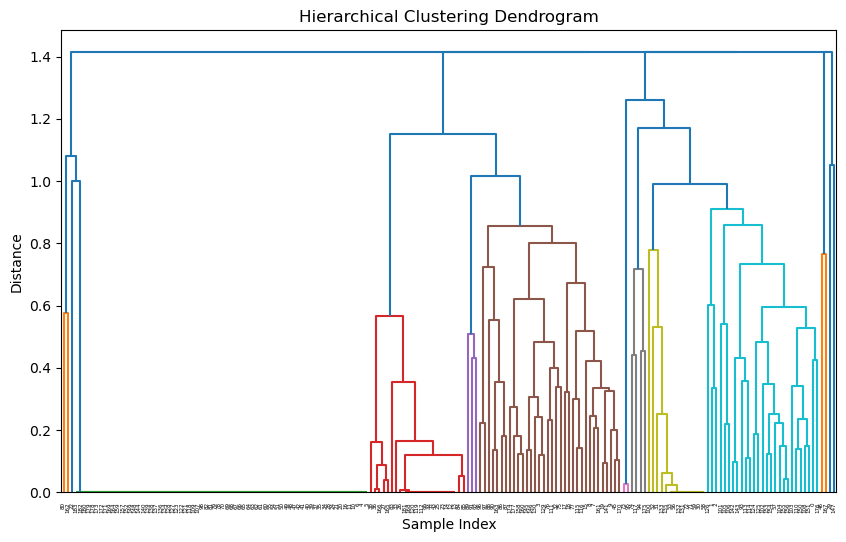

In [23]:
# 绘制层次聚合的树状图
plt.figure(figsize=(10, 6))
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=4,)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [27]:
# 根据层次聚合结果获取聚类标签
threshold = 1.35  # 设定阈值
clusters = fcluster(mergings, threshold, criterion='distance')
# 获取聚类簇的数量
num_clusters = len(np.unique(clusters))
print(num_clusters)

5


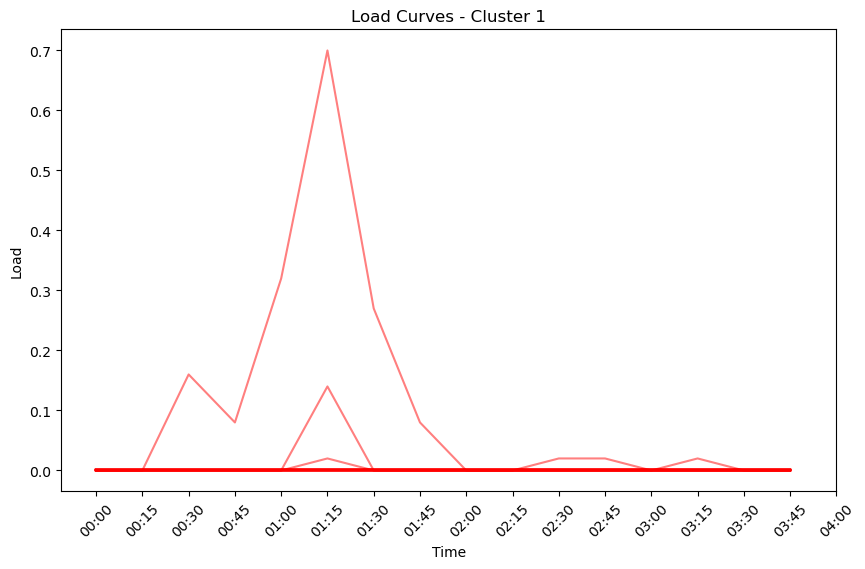

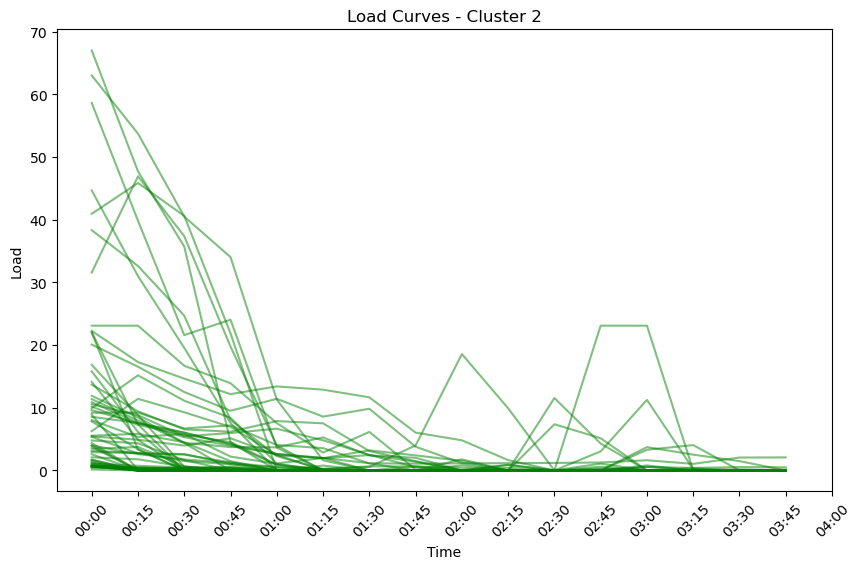

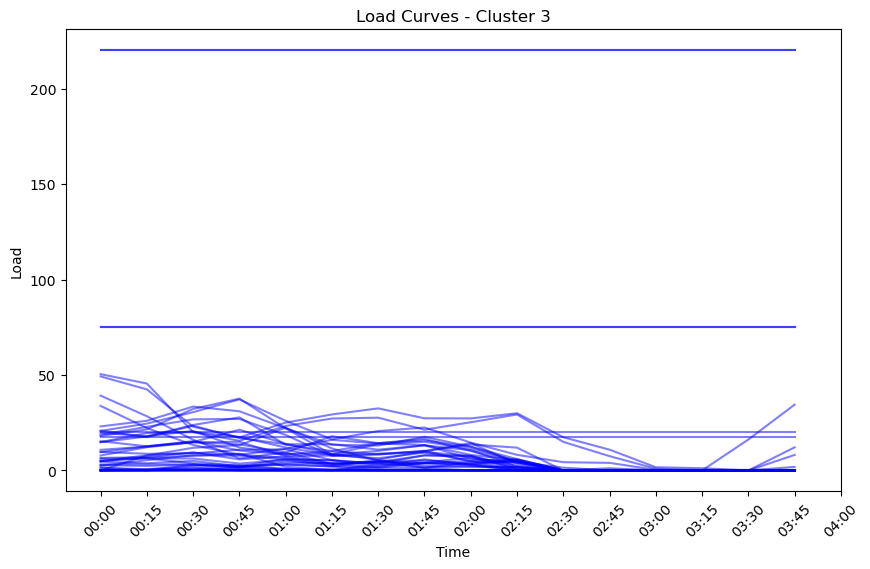

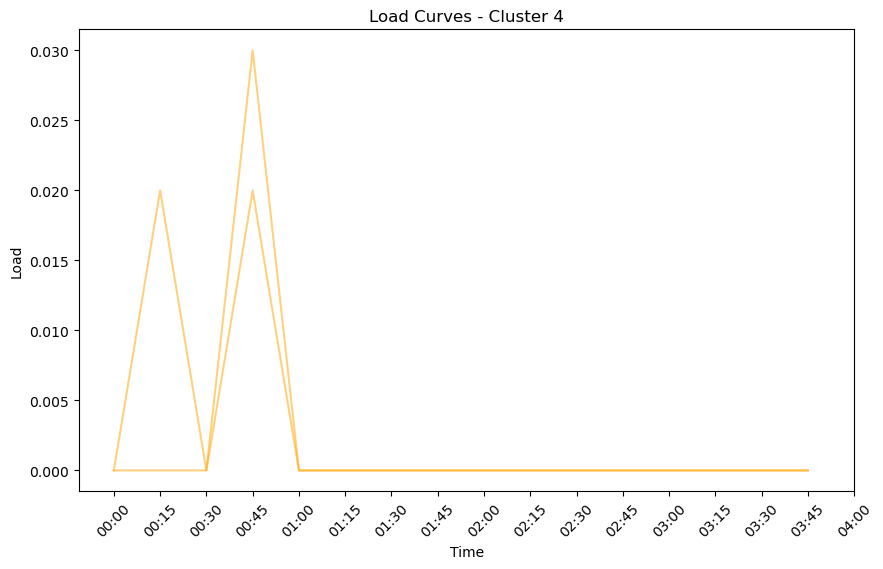

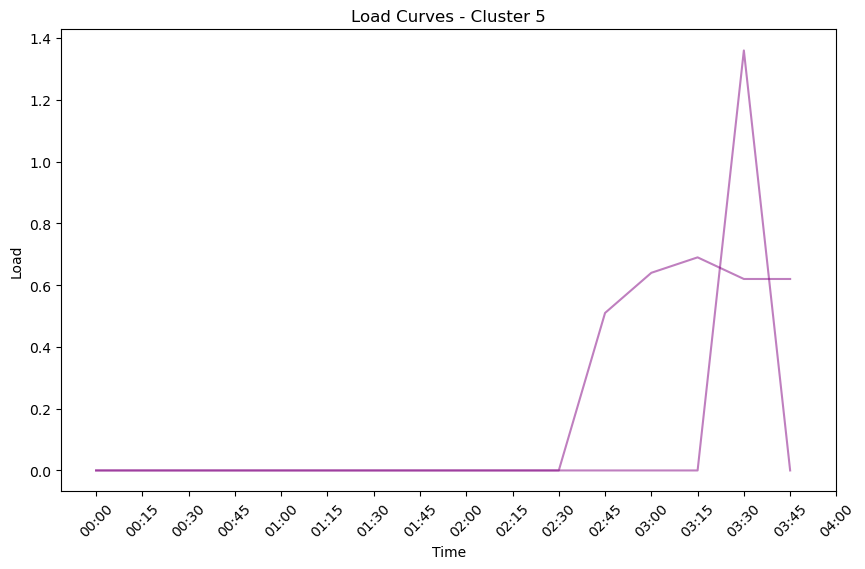

16


In [54]:
# 定义颜色列表
colors = ['red', 'green', 'blue', 'orange', 'purple']

# 绘制每个聚类簇的负荷曲线
num_intervals = renewable_data.shape[1]  # 时间间隔数量
interval_labels = pd.date_range(start='00:00', end='4:00', freq='15min').strftime('%H:%M')  # 生成时间标签
for cluster_id in range(1, num_clusters+1):
    plt.figure(figsize=(10, 6))
    for i in range(len(clusters)):
        if clusters[i] == cluster_id:
            plt.plot(range(num_intervals), renewable_data[i], color=colors[cluster_id-1], alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title(f'Load Curves - Cluster {cluster_id}')
    plt.xticks(range(0, num_intervals+1), interval_labels, rotation=45)  # 设置x轴刻度和标签
    plt.savefig(f'cluster_{cluster_id}_load_curve.png')  # 保存图像
    plt.show()
    plt.close()  # 关闭图像窗口
print(num_intervals)

In [56]:
# 将聚类结果标记在loadweather数据集的Cluster列上
renewable_df.loc[:, 'Cluster'] = fcluster(mergings, 5, criterion='maxclust')

# 保存修改后的数据集到原始CSV文件
renewable_df.to_csv('new_renewable.csv', index=False)

In [49]:
#-----------------------------------------------------
# 不进行分24一组
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

loadweather_data = pd.read_csv('new_renewable.csv', nrows=171)#读到表格172的位置

loadweather_data1 = pd.read_csv('new_renewable.csv', skiprows=range(1, 172), nrows=13)

# 提取关键影响因素
key_features = loadweather_data.columns[1:17]
# key_features = loadweather_data.iloc[0:0,1:17]
# 提取特征和目标变量
X = loadweather_data.iloc[0:,1:17]
y = loadweather_data['Cluster']
X1= loadweather_data1.iloc[0:,1:17]



# 构建决策树模型
clf = DecisionTreeClassifier()

# 计算特征重要性
clf.fit(X, y)
feature_importance = clf.feature_importances_

# 构建包含特征重要性的特征列表
key_features_with_importance = []
for feature, importance in zip(key_features, feature_importance):
    key_features_with_importance.append((feature, importance))
print(key_features_with_importance)
# 根据特征重要性排序特征列表
key_features_with_importance.sort(key=lambda x: x[1], reverse=True)

# 提取按重要性排序后的特征
sorted_key_features = [feature for feature, _ in key_features_with_importance]
print(sorted_key_features)
# 构建决策树模型，并使用排序后的特征进行训练
clf = DecisionTreeClassifier()
clf.fit(X[sorted_key_features], y)



# 使用决策树进行分类
predicted_clusters = clf.predict(X1[sorted_key_features])


from sklearn.tree import export_text

# # 输出决策树模型

# # 打印分类预测结果
for i, cluster in enumerate(predicted_clusters):
     print(f"样本 {i+1} 的预测类别为: {cluster}")
# # 将预测的类别值添加到newdata1表格的fCluster列中
# loadweather_data1['fCluster'] = predicted_clusters

# # 将预测的类别值添加到newdata1表格的fCluster列中
# loadweather_data1['fCluster'] = predicted_clusters.tolist() + [None] * (len(loadweather_data1) - len(predicted_clusters))

# # 将预测的类别值添加到newdata1表格的fCluster列中
# loadweather_data1['fCluster'] = predicted_clusters.tolist() + [None] * (len(loadweather_data1) - len(predicted_clusters))

# # 打印修改后的newdata1表格
# loadweather_data = pd.concat([loadweather_data, loadweather_data1])
# loadweather_data.to_csv('newdata.csv', index=False)

[('2023-06-01 00:15:00', 0.5094812768274863), ('2023-06-01 00:30:00', 0.0616390368313097), ('2023-06-01 00:45:00', 0.017063872582267242), ('2023-06-01 01:00:00', 0.00815587846486865), ('2023-06-01 01:15:00', 0.0), ('2023-06-01 01:30:00', 0.011199980144079533), ('2023-06-01 01:45:00', 0.02252156478365053), ('2023-06-01 02:00:00', 0.0), ('2023-06-01 02:15:00', 0.25327546676925566), ('2023-06-01 02:30:00', 0.06088144524979431), ('2023-06-01 02:45:00', 0.0), ('2023-06-01 03:00:00', 0.023107327455153547), ('2023-06-01 03:15:00', 0.0), ('2023-06-01 03:30:00', 0.0), ('2023-06-01 03:45:00', 0.032674150892134685), ('2023-06-01 04:00:00', 0.0)]
['2023-06-01 00:15:00', '2023-06-01 02:15:00', '2023-06-01 00:30:00', '2023-06-01 02:30:00', '2023-06-01 03:45:00', '2023-06-01 03:00:00', '2023-06-01 01:45:00', '2023-06-01 00:45:00', '2023-06-01 01:30:00', '2023-06-01 01:00:00', '2023-06-01 01:15:00', '2023-06-01 02:00:00', '2023-06-01 02:45:00', '2023-06-01 03:15:00', '2023-06-01 03:30:00', '2023-06-01